In [44]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB

In [45]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abmir\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [46]:
df = pd.read_csv('Train_rev1.csv')

In [47]:
df_sampled = df.sample(n=2500, random_state=42)

### Preprocess the text

In [48]:
def clean_text(text):
    if isinstance(text, str):
        text = text.lower()  # lowercase
        text = re.sub(r'\d+', '', text)  # numbers
        text = re.sub(r'\W+', ' ', text)  #  special characters
        text = re.sub(r'\s+', ' ', text).strip()  # extra spaces
        return text
    return ""

In [49]:
df_sampled["FullDescription"] = df_sampled["FullDescription"].apply(clean_text)

In [50]:
salary_threshold = df_sampled["SalaryNormalized"].quantile(0.75)
df_sampled["SalaryCategory"] = (df_sampled["SalaryNormalized"] >= salary_threshold).astype(int)

In [51]:
# split into train and test
train_df, test_df = train_test_split(df_sampled, test_size=0.2, random_state=42)

In [52]:
tfidf = TfidfVectorizer(max_features=5000, stop_words=stopwords.words("english"), sublinear_tf=True)

In [53]:
X_train = tfidf.fit_transform(train_df["FullDescription"])
y_train = train_df["SalaryCategory"]

In [54]:
X_test = tfidf.transform(test_df["FullDescription"])
y_test = test_df["SalaryCategory"]

### Train and tune the models

In [73]:
models = {
    "Multinomial Naïve Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC()
}

param_grid = {
    "Multinomial Naïve Bayes": {'alpha': [0.01, 0.1, 1, 10]},
    "Logistic Regression": {
        'C': [0.01, 0.1, 1, 10, 100],  
        'solver': ['liblinear', 'lbfgs'],  
        'penalty': ['l2']  
    },
    "Random Forest": {
        'n_estimators': [50, 100, 200, 500],  
        'max_depth': [5, 10, 20, 50, None], 
        'min_samples_split': [2, 5, 10],  
        'min_samples_leaf': [1, 2, 5]  
    },
    "SVM": {'C': [0.1, 1, 10]
    }
}
best_model = None
best_accuracy = 0

for model_name, model in models.items():
    grid = GridSearchCV(model, param_grid[model_name], cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)
    
    y_pred = grid.best_estimator_.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"Best Model for {model_name}: {grid.best_params_}")
    print(f"Accuracy: {accuracy:.4f}")
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = grid.best_estimator_

y_pred_best = best_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred_best)

Best Model for Multinomial Naïve Bayes: {'alpha': 0.1}
Accuracy: 0.7920
Best Model for Logistic Regression: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy: 0.8100


c:\Users\abmir\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Model for Random Forest: {'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 0.7700
Best Model for SVM: {'C': 10}
Accuracy: 0.7980


In [74]:
print(f"The best model is {best_model}")
print(f"with accuracy of {best_accuracy}")

The best model is LogisticRegression(C=10, solver='liblinear')
with accuracy of 0.81


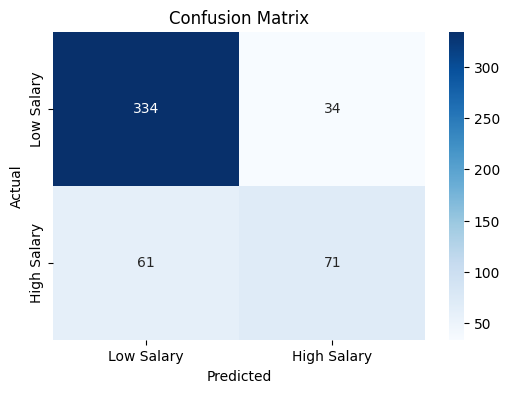

In [75]:
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Low Salary", "High Salary"], yticklabels=["Low Salary", "High Salary"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### Extract Top 10 Words for High and Low Salary

In [77]:
feature_names = np.array(tfidf.get_feature_names_out())

if isinstance(best_model, MultinomialNB):
    # For Naïve Bayes, use log probabilities to determine word importance
    coefficients = best_model.feature_log_prob_[1] - best_model.feature_log_prob_[0]
else:
    # For other models, use coefficients or feature importance
    coefficients = best_model.coef_.flatten() if hasattr(best_model, 'coef_') else best_model.feature_importances_

top_10_high_salary = feature_names[np.argsort(coefficients)[-10:]]
top_10_low_salary = feature_names[np.argsort(coefficients)[:10]]

print("Top 10 words for HIGH salary jobs:", top_10_high_salary)
print("Top 10 words for LOW salary jobs:", top_10_low_salary)

Top 10 words for HIGH salary jobs: ['operations' 'architect' 'leadership' 'managing' 'consumer' 'lead' 'head'
 'strategic' 'director' 'senior']
Top 10 words for LOW salary jobs: ['applicants' 'customer' 'hours' 'training' 'required' 'assistant'
 'standard' 'database' 'basic' 'people']
